# Semantic matching explains search behavior

In [1]:
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')
from src.visualization import utils
utils.setup_matplotlib()

In [2]:
data_split  = 'trainval'
path_maps   = '/Volumes/T7/data/coco/maps/m'

scores = {}
for name_maps in ['smm', 'smm_rnd', 'ittikoch', 'deepgaze', 'human_early']:
    scores[name_maps] = {}
    for name_scores in ['sauc']:
        scores[name_maps][name_scores] = {}
        with open(f'{path_maps}/{name_maps}/{name_scores}_{data_split}.pkl', 'rb') as f:
            score = pickle.load(f)
        scores[name_maps][name_scores]['tp'] = utils.mns(score['tp'])
        scores[name_maps][name_scores]['ta'] = utils.mns(score['ta'])

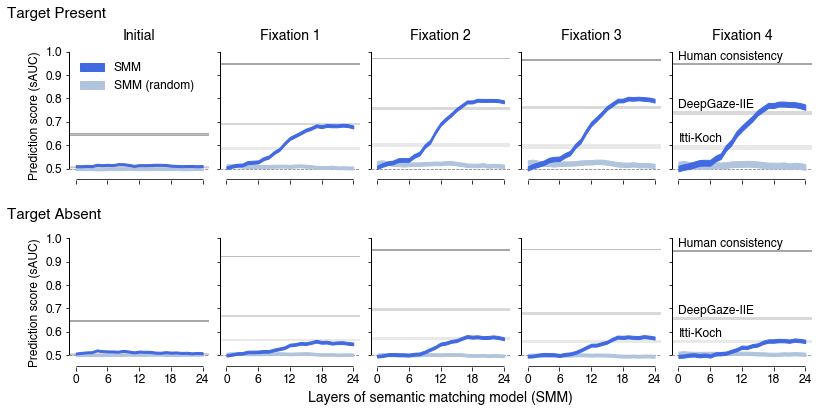

In [3]:
# plot parameters
nm = 'sauc'
chance = 0.5
ylims  = [0.45,1.0]
layers = np.arange(0,25)
scan_orders = [0,1,2,3,4]
os_i, os_d, os_h = 0.012, 0.012, 0.012

f,ax = plt.subplots(2,len(scan_orders),figsize=[13.3,5.8], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.08, hspace=0.45)
for i in range(len(scan_orders)):
    for i_cond, cond in enumerate(['tp', 'ta']):
        # SMM
        m, s = scores['smm'][nm][cond]
        ax[i_cond,i].fill_between(layers, m[i]-s[i], m[i]+s[i], label='SMM', color='royalblue')
        
        # SMM-random
        m, s = scores['smm_rnd'][nm][cond]
        ax[i_cond,i].fill_between(layers, m[i]-s[i], m[i]+s[i], label='SMM (random)', color='lightsteelblue', zorder=-1)

        # Itti-Koch
        m, s = scores['ittikoch'][nm][cond]
        ax[i_cond,i].axhspan(m[i]-s[i], m[i]+s[i], color='darkgray', linewidth=0, alpha=0.25, zorder=-2)
        if i == 4: ax[i_cond,i].text(0, (m+s)[-1]+os_i, 'Itti-Koch', color='k')
        
        # DeepGaze-IIE
        m, s = scores['deepgaze'][nm][cond]
        ax[i_cond,i].axhspan(m[i]-s[i], m[i]+s[i], color='dimgray', linewidth=0, alpha=0.25, zorder=-2)
        if i == 4: ax[i_cond,i].text(0, (m+s)[-1]+os_i, 'DeepGaze-IIE', color='k')
        
        # Human consistency
        m, s = scores['human_early'][nm][cond]
        ax[i_cond,i].axhspan(m[i]-s[i], m[i]+s[i], color='k', linewidth=1, alpha=0.25, zorder=-2)
        if i == 4: ax[i_cond,i].text(0, (m+s)[-1]+os_h, 'Human consistency', color='k')

        # Chance
        ax[i_cond,i].axhline(y=chance, linestyle='dashed', color='gray', zorder=-2, linewidth=0.8)

    # Other
    if i == 0: ax[0,i].set_title(f'Initial', fontsize=14)
    else: ax[0,i].set_title(f'Fixation {i}', fontsize=14)

plt.ylim(ylims)
for i in range(5):
    utils.draw_publish_axis(ax[0,i], [0,24], [0.5,1], None, np.linspace(0.5,1.,num=6))
    utils.draw_publish_axis(ax[1,i], [0,24], [0.5,1], [0,6,12,18,24], np.linspace(0.5,1.,num=6))
        
plt.text(0.06, 0.96, 'Target Present', fontsize=15, transform=plt.gcf().transFigure)
plt.text(0.06, 0.48, 'Target Absent',  fontsize=15, transform=plt.gcf().transFigure)
ax[0,0].set_ylabel('Prediction score (sAUC)')
ax[1,0].set_ylabel('Prediction score (sAUC)')
ax[1,2].set_xlabel('Layers of semantic matching model (SMM)', fontsize=14)
ax[0,0].legend(frameon=False, loc='upper left')
plt.savefig(f'{utils.DIR_FIGURE}/fig2.pdf', bbox_inches='tight')
plt.show()

---
## Significance tests

In [18]:
scores = {}
for name_maps in ['smm', 'smm_rnd', 'deepgaze', 'ittikoch']:
    scores[name_maps] = {}
    for name_scores in ['sauc', 'nss', 'auc']:
        scores[name_maps][name_scores] = {}
        with open(f'{path_maps}/{name_maps}/{name_scores}_agg_{data_split}.pkl', 'rb') as f:
            score = pickle.load(f)
        scores[name_maps][name_scores]['tp'] = score['tp']
        scores[name_maps][name_scores]['ta'] = score['ta']

In [5]:
from scipy.stats import ttest_1samp

def ttest(v1, v2):
    nnan = (~np.isnan(v1)) & (~np.isnan(v2))
    pval = ttest_1samp(v1[nnan] - v2[nnan], 0, alternative='greater').pvalue
    return pval

nm = 'sauc'
ps = np.nan*np.zeros((25,2))
for i_layer in range(25):
    ps[i_layer,0] = ttest(scores['smm'][nm]['tp'][i_layer],scores['smm_rnd'][nm]['tp'][i_layer])
    ps[i_layer,1] = ttest(scores['smm'][nm]['ta'][i_layer],scores['smm_rnd'][nm]['ta'][i_layer])

print(ps[1:,0] <= 0.05/24)
print(ps[1:,1] <= 0.05/24)

[False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
[False False False False False False False False False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


In [6]:
from scipy.optimize import minimize
from scipy.stats import ttest_1samp

def ttest(x, mu=0.5):
    nnan = ~np.isnan(x)
    res  = ttest_1samp(x[nnan], mu)
    return res

def logistic(l,k,x0,xx):
    return l/(1.+np.exp(-k*(xx-x0))) + 0.5

def loss(par, mts):
    l, k, x0 = par
    xx = np.arange(0,25)
    ts = logistic(l,k,x0,xx)
    
    _l = np.mean((mts-ts)**2)
    return _l

r squared:  0.9965040174896681


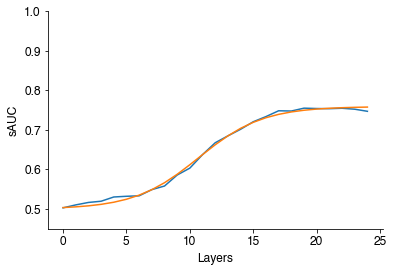

r squared:  0.9898585787306818


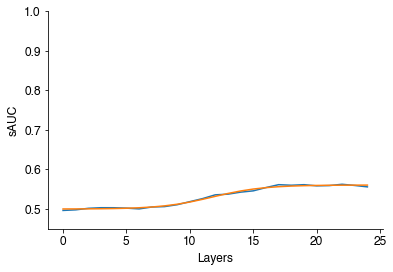

r squared:  -0.5728505951159069


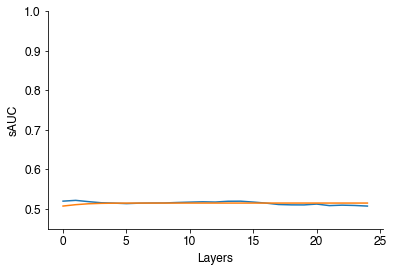

r squared:  -0.12830757138462934


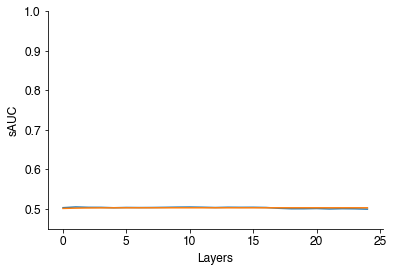

In [7]:
ts = np.mean(scores['smm']['sauc']['tp'],axis=-1)
rx = minimize(loss, [0,1.,0], args=(ts), bounds=[[-0.5,0.5],[0,20.],[-20,20.]])
ssr = np.sum( (ts-logistic(*rx['x'], np.arange(0,25)))**2 )
sst = np.sum( (ts-np.mean(ts))**2 )
print('r squared: ', 1. - ssr/sst)
plt.plot(np.arange(0,25), ts)
plt.plot(np.arange(0,25), logistic(*rx['x'], np.arange(0,25)))
plt.xlabel('Layers'); plt.ylabel('sAUC'); plt.ylim([0.45,1.0])
plt.show()

ts = np.mean(scores['smm']['sauc']['ta'],axis=-1)
rx = minimize(loss, [0,1.,0], args=(ts), bounds=[[-0.5,0.5],[0,20.],[-20,20.]])
ssr = np.sum( (ts-logistic(*rx['x'], np.arange(0,25)))**2 )
sst = np.sum( (ts-np.mean(ts))**2 )
print('r squared: ', 1. - ssr/sst)
plt.plot(np.arange(0,25), ts)
plt.plot(np.arange(0,25), logistic(*rx['x'], np.arange(0,25)))
plt.xlabel('Layers'); plt.ylabel('sAUC'); plt.ylim([0.45,1.0])
plt.show()

ts = np.mean(scores['smm_rnd']['sauc']['tp'],axis=-1)
rx = minimize(loss, [0,1.,0], args=(ts), bounds=[[-0.5,0.5],[0,20.],[-20,20.]])
ssr = np.sum( (ts-logistic(*rx['x'], np.arange(0,25)))**2 )
sst = np.sum( (ts-np.mean(ts))**2 )
print('r squared: ', 1. - ssr/sst)
plt.plot(np.arange(0,25), ts)
plt.plot(np.arange(0,25), logistic(*rx['x'], np.arange(0,25)))
plt.xlabel('Layers'); plt.ylabel('sAUC'); plt.ylim([0.45,1.0])
plt.show()

ts = np.mean(scores['smm_rnd']['sauc']['ta'],axis=-1)
rx = minimize(loss, [0,1.,0], args=(ts), bounds=[[-0.5,0.5],[0,20.],[-20,20.]])
ssr = np.sum( (ts-logistic(*rx['x'], np.arange(0,25)))**2 )
sst = np.sum( (ts-np.mean(ts))**2 )
print('r squared: ', 1. - ssr/sst)
plt.plot(np.arange(0,25), ts)
plt.plot(np.arange(0,25), logistic(*rx['x'], np.arange(0,25)))
plt.xlabel('Layers'); plt.ylabel('sAUC'); plt.ylim([0.45,1.0])
plt.show()

In [19]:
# bootstrapping
n_boot = 10000
n_task = 2489

np.random.seed(2023)
L_tp = np.nan*np.zeros( (n_boot,3) )
L_ta = np.nan*np.zeros( (n_boot,3) )
Lrtp = np.nan*np.zeros( (n_boot,3) )
Lrta = np.nan*np.zeros( (n_boot,3) )
Ldtp = np.nan*np.zeros( (n_boot,3) )
Ldta = np.nan*np.zeros( (n_boot,3) )
Litp = np.nan*np.zeros( (n_boot,3) )
Lita = np.nan*np.zeros( (n_boot,3) )
for i_boot in range(n_boot):
    idx_boot_tp = np.random.choice(n_task, n_task, replace=True)
    idx_boot_ta = np.random.choice(n_task, n_task, replace=True)
    
    ts = np.mean(scores['smm']['sauc']['tp'][:,idx_boot_tp],axis=-1)
    rx = minimize(loss, [0,1.,0], args=(ts), bounds=[[-0.5,0.5],[0,20.],[-20,20.]])
    L_tp[i_boot] = rx['x']

    ts = np.mean(scores['smm']['sauc']['ta'][:,idx_boot_ta],axis=-1)
    rx = minimize(loss, [0,1.,0], args=(ts), bounds=[[-0.5,0.5],[0,20.],[-20,20.]])
    L_ta[i_boot] = rx['x']

    ts = np.mean(scores['smm_rnd']['sauc']['tp'][:,idx_boot_tp],axis=-1)
    rx = minimize(loss, [0,1.,0], args=(ts), bounds=[[-0.5,0.5],[0,20.],[-20,20.]])
    Lrtp[i_boot] = rx['x']

    ts = np.mean(scores['smm_rnd']['sauc']['ta'][:,idx_boot_ta],axis=-1)
    rx = minimize(loss, [0,1.,0], args=(ts), bounds=[[-0.5,0.5],[0,20.],[-20,20.]])
    Lrta[i_boot] = rx['x']

    # ts = np.mean(scores['deepgaze']['sauc']['tp'][idx_boot_tp],axis=-1)
    # rx = minimize(loss, [0,1.,0], args=(ts), bounds=[[-0.5,0.5],[0,20.],[-20,20.]])
    # Ldtp[i_boot] = rx['x']

    # ts = np.mean(scores['deepgaze']['sauc']['ta'][idx_boot_ta],axis=-1)
    # rx = minimize(loss, [0,1.,0], args=(ts), bounds=[[-0.5,0.5],[0,20.],[-20,20.]])
    # Ldta[i_boot] = rx['x']

    # ts = np.mean(scores['ittikoch']['sauc']['tp'][idx_boot_tp],axis=-1)
    # rx = minimize(loss, [0,1.,0], args=(ts), bounds=[[-0.5,0.5],[0,20.],[-20,20.]])
    # Litp[i_boot] = rx['x']

    # ts = np.mean(scores['ittikoch']['sauc']['ta'][idx_boot_ta],axis=-1)
    # rx = minimize(loss, [0,1.,0], args=(ts), bounds=[[-0.5,0.5],[0,20.],[-20,20.]])
    # Lita[i_boot] = rx['x']

In [17]:
print(0.5 + np.mean(L_tp[:,0]), np.std(L_tp[:,0])*1.96)
print(0.5 + np.mean(L_ta[:,0]), np.std(L_ta[:,0])*1.96)

0.7594244022932763 0.011061870847473
0.5604571558365585 0.009194212280186936


In [22]:
ts = np.mean(scores['smm']['sauc']['tp'],axis=-1)
rx = minimize(loss, [0,1.,0], args=(ts), bounds=[[-0.5,0.5],[0,20.],[-20,20.]])
Ltp = rx['x'][0] + 0.5
print(Ltp)

ts = np.mean(scores['smm']['sauc']['ta'],axis=-1)
rx = minimize(loss, [0,1.,0], args=(ts), bounds=[[-0.5,0.5],[0,20.],[-20,20.]])
Lta = rx['x'][0] + 0.5
print(Lta)

0.7592216456289889
0.5606620774948358


In [39]:
n_boot = 100000
n_size = 2489
nm = 'sauc'

dist_dg = np.nan*np.zeros((n_boot,2))
dist_ik = np.nan*np.zeros((n_boot,2))
np.random.seed(2023)
for i in range(n_boot):
    rand_sgn_tp = np.random.choice([-1,1], n_size, replace=True)
    rand_sgn_ta = np.random.choice([-1,1], n_size, replace=True)

    dist_dg[i,0] = np.mean( np.abs(Ltp-scores['deepgaze'][nm]['tp'])*rand_sgn_tp )
    dist_dg[i,1] = np.mean( np.abs(Lta-scores['deepgaze'][nm]['ta'])*rand_sgn_ta )
    dist_ik[i,0] = np.mean( np.abs(Ltp-scores['ittikoch'][nm]['tp'])*rand_sgn_tp )
    dist_ik[i,1] = np.mean( np.abs(Lta-scores['ittikoch'][nm]['ta'])*rand_sgn_ta )

In [46]:
n_boot = 100000
n_size = 2489
nm = 'sauc'

conf_dg = np.nan*np.zeros((n_boot,2))
conf_ik = np.nan*np.zeros((n_boot,2))
np.random.seed(2023)
for i in range(n_boot):
    rand_idx_tp = np.random.choice(n_size, n_size, replace=True)
    rand_idx_ta = np.random.choice(n_size, n_size, replace=True)

    conf_dg[i,0] = np.mean( Ltp-scores['deepgaze'][nm]['tp'][rand_idx_tp] )
    conf_dg[i,1] = np.mean( Lta-scores['deepgaze'][nm]['ta'][rand_idx_ta] )
    conf_ik[i,0] = np.mean( Ltp-scores['ittikoch'][nm]['tp'][rand_idx_tp] )
    conf_ik[i,1] = np.mean( Lta-scores['ittikoch'][nm]['ta'][rand_idx_ta] )

In [47]:
diff = Ltp-np.mean(scores['deepgaze'][nm]['tp'])
print( diff, np.mean(np.abs(diff) < np.abs(dist_dg[:,0])), np.quantile(conf_dg[:,0], [0.025,0.975]) )

diff = Lta-np.mean(scores['deepgaze'][nm]['ta'])
print( diff, np.mean(np.abs(diff) < np.abs(dist_dg[:,1])), np.quantile(conf_dg[:,1], [0.025,0.975]) )

diff = Ltp-np.mean(scores['ittikoch'][nm]['tp'])
print( diff, np.mean(np.abs(diff) < np.abs(dist_ik[:,0])), np.quantile(conf_ik[:,0], [0.025,0.975]) )

diff = Lta-np.mean(scores['ittikoch'][nm]['ta'])
print( diff, np.mean(np.abs(diff) < np.abs(dist_ik[:,1])), np.quantile(conf_ik[:,1], [0.025,0.975]) )

0.030956114375683685 0.0 [0.02491153 0.03703261]
-0.10834443263238025 0.0 [-0.11284233 -0.10381013]
0.1659414318579473 0.0 [0.15928769 0.17254407]
0.0011804088769458154 0.53208 [-0.00251854  0.00488454]


---

In [10]:
data_split  = 'trainval'
path_maps   = '/Volumes/T7/data/coco/maps/m'

scores = {}
for name_maps in ['smm', 'smm_rnd', 'ittikoch', 'deepgaze', 'human_early']:
    scores[name_maps] = {}
    for name_scores in ['sauc']:
        scores[name_maps][name_scores] = {}
        with open(f'{path_maps}/{name_maps}/ntrgt_{name_scores}_{data_split}.pkl', 'rb') as f:
            score = pickle.load(f)
        if name_maps == 'human_early':
            scores[name_maps][name_scores]['tp'] = utils.mns(score['tp'])
        else:
            scores[name_maps][name_scores]['tp'] = utils.mns(score)

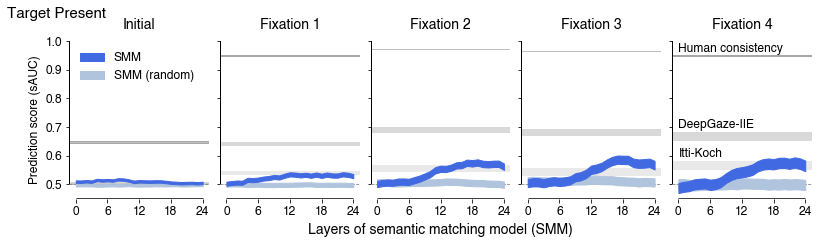

In [11]:
# plot parameters
nm = 'sauc'
chance = 0.5
ylims  = [0.45,1.0]
layers = np.arange(0,25)
scan_orders = [0,1,2,3,4]
os_i, os_d, os_h = 0.012, 0.012, 0.012

f,ax = plt.subplots(1,len(scan_orders),figsize=[13.3,2.9], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.08, hspace=0.45)
for i in range(len(scan_orders)):
    for i_cond, cond in enumerate(['tp']):
        # SMM
        m, s = scores['smm'][nm][cond]
        ax[i].fill_between(layers, m[i]-s[i], m[i]+s[i], label='SMM', color='royalblue')
        
        # SMM-random
        m, s = scores['smm_rnd'][nm][cond]
        ax[i].fill_between(layers, m[i]-s[i], m[i]+s[i], label='SMM (random)', color='lightsteelblue', zorder=-1)

        # Itti-Koch
        m, s = scores['ittikoch'][nm][cond]
        ax[i].axhspan(m[i]-s[i], m[i]+s[i], color='darkgray', linewidth=0, alpha=0.25, zorder=-2)
        if i == 4: ax[i].text(0, (m+s)[-1]+os_i, 'Itti-Koch', color='k')
        
        # DeepGaze-IIE
        m, s = scores['deepgaze'][nm][cond]
        ax[i].axhspan(m[i]-s[i], m[i]+s[i], color='dimgray', linewidth=0, alpha=0.25, zorder=-2)
        if i == 4: ax[i].text(0, (m+s)[-1]+os_i, 'DeepGaze-IIE', color='k')
        
        # Human consistency
        m, s = scores['human_early'][nm][cond]
        ax[i].axhspan(m[i]-s[i], m[i]+s[i], color='k', linewidth=1, alpha=0.25, zorder=-2)
        if i == 4: ax[i].text(0, (m+s)[-1]+os_h, 'Human consistency', color='k')

        # Chance
        ax[i].axhline(y=chance, linestyle='dashed', color='gray', zorder=-2, linewidth=0.8)

    # Other
    if i == 0: ax[i].set_title(f'Initial', fontsize=14)
    else: ax[i].set_title(f'Fixation {i}', fontsize=14)

plt.ylim(ylims)
for i in range(5):
    utils.draw_publish_axis(ax[i], [0,24], [0.5,1], [0,6,12,18,24], np.linspace(0.5,1.,num=6))
        
plt.text(0.06, 0.99, 'Target Present', fontsize=15, transform=plt.gcf().transFigure)
ax[0].set_ylabel('Prediction score (sAUC)')
ax[2].set_xlabel('Layers of semantic matching model (SMM)', fontsize=14)
ax[0].legend(frameon=False, loc='upper left')
plt.savefig(f'{utils.DIR_FIGURE}/fig2_exclude.pdf', bbox_inches='tight')
plt.show()